In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from data import ZillowDataProcessor

In [2]:
# NOTE: change to local file storage
processor = ZillowDataProcessor(
    '/mnt/c/CS431/properties_2016.csv',
    '/mnt/c/CS431/properties_2017.csv',
    '/mnt/c/CS431/train_2016_v2.csv',
    '/mnt/c/CS431/train_2017.csv'
)

processor.prepare()
processed_df = processor.get_processed_data()

📦 Loading data...
🧹 Cleaning property datasets...
🛑 Dropping 24 columns from Properties 2016 (>80.0% missing)
🛑 Dropping 24 columns from Properties 2017 (>80.0% missing)

🔗 Merging training data with property data
✅ Train 2016 shape: (90275, 20)
✅ Train 2017 shape: (77613, 20)
✂️ Filtering outliers in logerror...
✅ Data ready for modeling!


In [3]:
print(processed_df.columns)
print(processed_df.dtypes)

Index(['parcelid', 'logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'numberofstories', 'taxamount'],
      dtype='object')
parcelid                          int64
logerror                        float64
transactiondate                   int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
garagecarcnt                    float64
garagetotalsqft                 float64
lotsizesquarefeet               float64
propertylandusetypeid           float64
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty             

In [4]:
features = processed_df.drop(columns='logerror')
label = processed_df['logerror'].values

In [5]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

Linear Regression

In [6]:
from linear_reggression import LinearModel
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
linear_model = LinearModel(features, label)

In [8]:
y_pred = linear_model.model.predict(linear_model.X_test)

In [9]:
r2 = r2_score(linear_model.y_test, y_pred)
mse = mean_squared_error(linear_model.y_test, y_pred)
print(f'R2 Score: {r2}')
print(f'Mean Squared Error: {mse}')

R2 Score: 0.007323446591417593
Mean Squared Error: 0.006734180661252891


LSTM

In [10]:
from LSTM import LSTMModel
from create_dataset import CreateDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [11]:
# hyperparameters
batch_size = 64
input_size = 19
output_size = 1
hidden_size = 128
num_layers = 2
dropout_rate = 0.3
learning_rate = 0.001
seq_length = 10

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(features, label, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = CreateDataset(X_train, y_train, seq_length)
val_dataset = CreateDataset(X_val, y_val, seq_length)
test_dataset = CreateDataset(X_test, y_test, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.00001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

cpu
Epoch 1/10, Loss: 0.0067
Epoch 2/10, Loss: 0.0067
Epoch 3/10, Loss: 0.0067
Epoch 4/10, Loss: 0.0067
Epoch 5/10, Loss: 0.0067
Epoch 6/10, Loss: 0.0067
Epoch 7/10, Loss: 0.0066
Epoch 8/10, Loss: 0.0066
Epoch 9/10, Loss: 0.0066
Epoch 10/10, Loss: 0.0066


In [24]:
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds.append(model(X_batch.to(device)).cpu().numpy())
        actuals.append(y_batch.numpy())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

preds = np.array(preds).flatten()
actuals = np.array(actuals).flatten()

mse = mean_squared_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f'R2 Score: {r2}')
print(f'Mean Squared Error: {mse}')

R2 Score: 0.0017590522766113281
Mean Squared Error: 0.006771300453692675


# RNN Model 

In [15]:
from RNN import RNNModel, RNNEvaluator
import matplotlib.pyplot as plt

In [16]:
# Use the same data split approach as the LSTM model, but with a shorter sequence length
X_train_rnn, X_temp_rnn, y_train_rnn, y_temp_rnn = train_test_split(features, label, test_size=0.3, random_state=42)
X_val_rnn, X_test_rnn, y_val_rnn, y_test_rnn = train_test_split(X_temp_rnn, y_temp_rnn, test_size=0.5, random_state=42)

# Convert to PyTorch tensors (if they're not already)
X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32) if not isinstance(X_train_rnn, torch.Tensor) else X_train_rnn
X_val_tensor = torch.tensor(X_val_rnn, dtype=torch.float32) if not isinstance(X_val_rnn, torch.Tensor) else X_val_rnn
X_test_tensor = torch.tensor(X_test_rnn, dtype=torch.float32) if not isinstance(X_test_rnn, torch.Tensor) else X_test_rnn
y_train_tensor = torch.tensor(y_train_rnn, dtype=torch.float32) if not isinstance(y_train_rnn, torch.Tensor) else y_train_rnn
y_val_tensor = torch.tensor(y_val_rnn, dtype=torch.float32) if not isinstance(y_val_rnn, torch.Tensor) else y_val_rnn
y_test_tensor = torch.tensor(y_test_rnn, dtype=torch.float32) if not isinstance(y_test_rnn, torch.Tensor) else y_test_rnn

# Set RNN hyperparameters
rnn_hidden_size = 128
rnn_num_layers = 2
rnn_dropout_rate = 0.3
rnn_seq_length = 10  # Using the same sequence length as LSTM for fair comparison

In [17]:
# Create datasets
train_dataset_rnn = CreateDataset(X_train_tensor, y_train_tensor, rnn_seq_length)
val_dataset_rnn = CreateDataset(X_val_tensor, y_val_tensor, rnn_seq_length)
test_dataset_rnn = CreateDataset(X_test_tensor, y_test_tensor, rnn_seq_length)

# Create dataloaders
batch_size_rnn = 64  # Same as LSTM for fair comparison
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size_rnn, shuffle=True)
val_loader_rnn = DataLoader(val_dataset_rnn, batch_size=batch_size_rnn, shuffle=False)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=batch_size_rnn, shuffle=False)

print(f"Training samples: {len(train_dataset_rnn)}")
print(f"Validation samples: {len(val_dataset_rnn)}")
print(f"Test samples: {len(test_dataset_rnn)}")
print(f"Input features: {X_train_rnn.shape[1]}")
print(f"Sequence length: {rnn_seq_length}")

Training samples: 114999
Validation samples: 24635
Test samples: 24635
Input features: 19
Sequence length: 10


/home/hzechter/projects/bigData/431_house_estimator/create_dataset.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/home/hzechter/projects/bigData/431_house_estimator/create_dataset.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


In [18]:
# Create and initialize the RNN model
input_size_rnn = X_train_rnn.shape[1]
output_size_rnn = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a simplified RNN model
rnn_model = RNNModel(
    input_size=input_size_rnn,
    hidden_size=rnn_hidden_size,
    num_layers=rnn_num_layers,
    dropout_rate=rnn_dropout_rate,
    output_size=output_size_rnn
).to(device)

# Initialize the RNN evaluator
rnn_evaluator = RNNEvaluator(rnn_model, device)

# Setup criterion and optimizer (same as LSTM for fair comparison)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=0.00001)

print(rnn_model)

Using device: cpu
RNNModel(
  (lstm): LSTM(19, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [19]:
# Train the RNN model
epochs = 10  # Same number of epochs as LSTM for fair comparison
print(f"Training RNN model for {epochs} epochs...")

train_losses, val_losses = rnn_evaluator.train_model(
    train_loader=train_loader_rnn,
    val_loader=val_loader_rnn,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs
)

Training RNN model for 10 epochs...
Epoch 1/10, Train Loss: 0.006729, Val Loss: 0.006828
Epoch 2/10, Train Loss: 0.006679, Val Loss: 0.006828
Epoch 3/10, Train Loss: 0.006674, Val Loss: 0.006819
Epoch 4/10, Train Loss: 0.006665, Val Loss: 0.006811
Epoch 5/10, Train Loss: 0.006659, Val Loss: 0.006816
Epoch 6/10, Train Loss: 0.006649, Val Loss: 0.006847
Epoch 7/10, Train Loss: 0.006641, Val Loss: 0.006797
Epoch 8/10, Train Loss: 0.006628, Val Loss: 0.006819
Epoch 9/10, Train Loss: 0.006615, Val Loss: 0.006799
Epoch 10/10, Train Loss: 0.006595, Val Loss: 0.006796


In [20]:
# Evaluate the RNN model
metrics, y_pred_rnn, y_true_rnn = rnn_evaluator.evaluate(test_loader_rnn)

# Calculate additional metrics
rnn_r2 = r2_score(y_true_rnn, y_pred_rnn)
rnn_mse = mean_squared_error(y_true_rnn, y_pred_rnn)

print(f"\nRNN Model Evaluation:")
print(f"R2 Score: {rnn_r2:.6f}")
print(f"Mean Squared Error: {rnn_mse:.6f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.6f}")

Evaluation Metrics:
MAE: 0.0525
MSE: 0.0067
RMSE: 0.0821

RNN Model Evaluation:
R2 Score: 0.006826
Mean Squared Error: 0.006737
Root Mean Squared Error: 0.082079


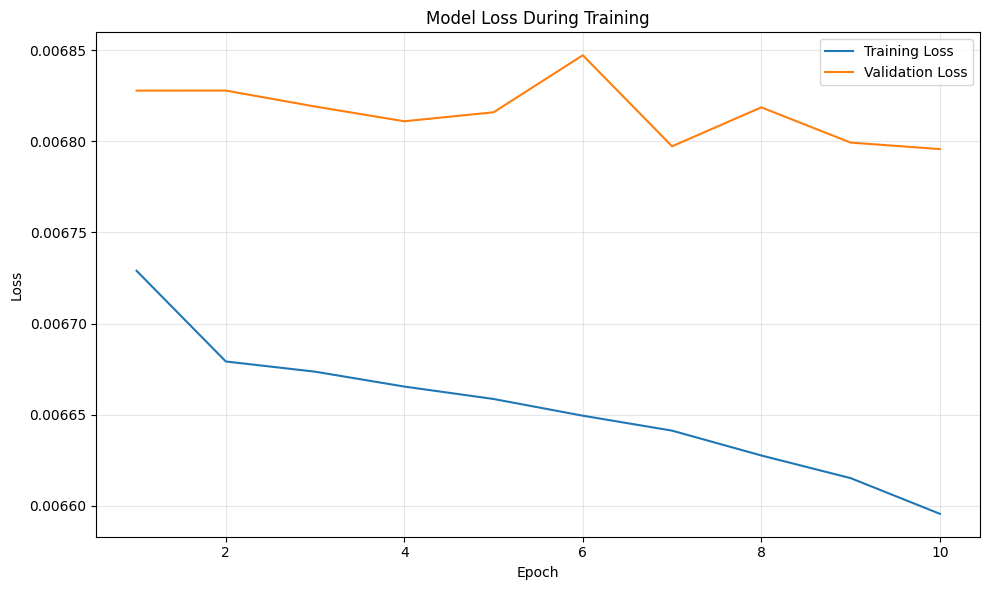

In [21]:
# Visualize training history
history_fig = rnn_evaluator.visualize_training_history()
plt.show()

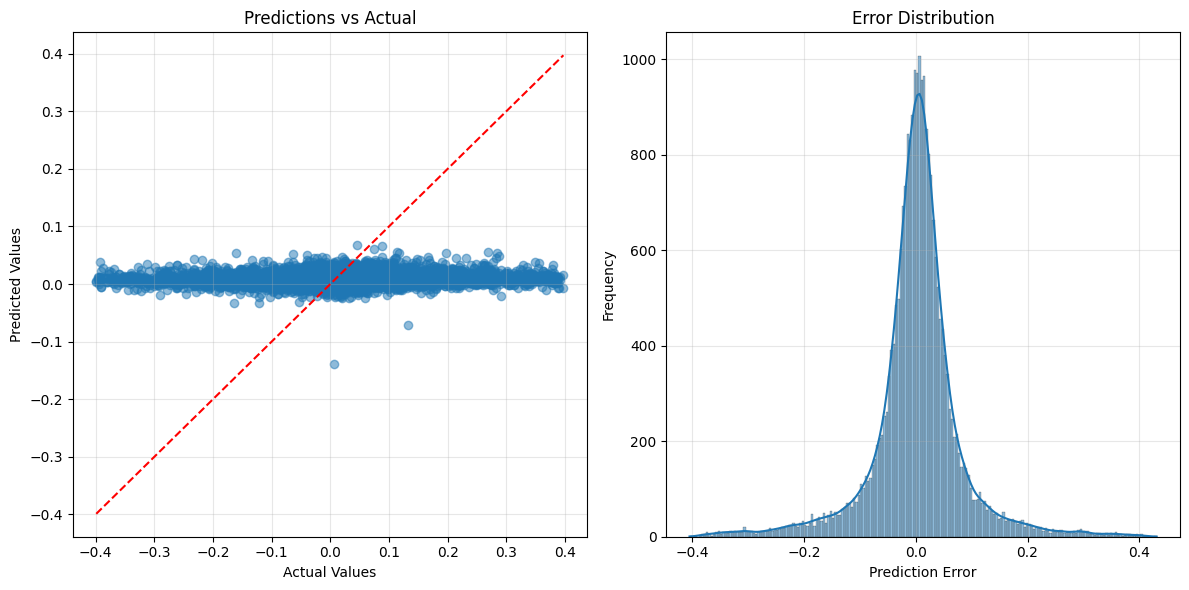

In [22]:
# Visualize predictions vs actual values
predictions_fig = rnn_evaluator.visualize_predictions(y_pred_rnn, y_true_rnn)
plt.show()

# Model Comparison

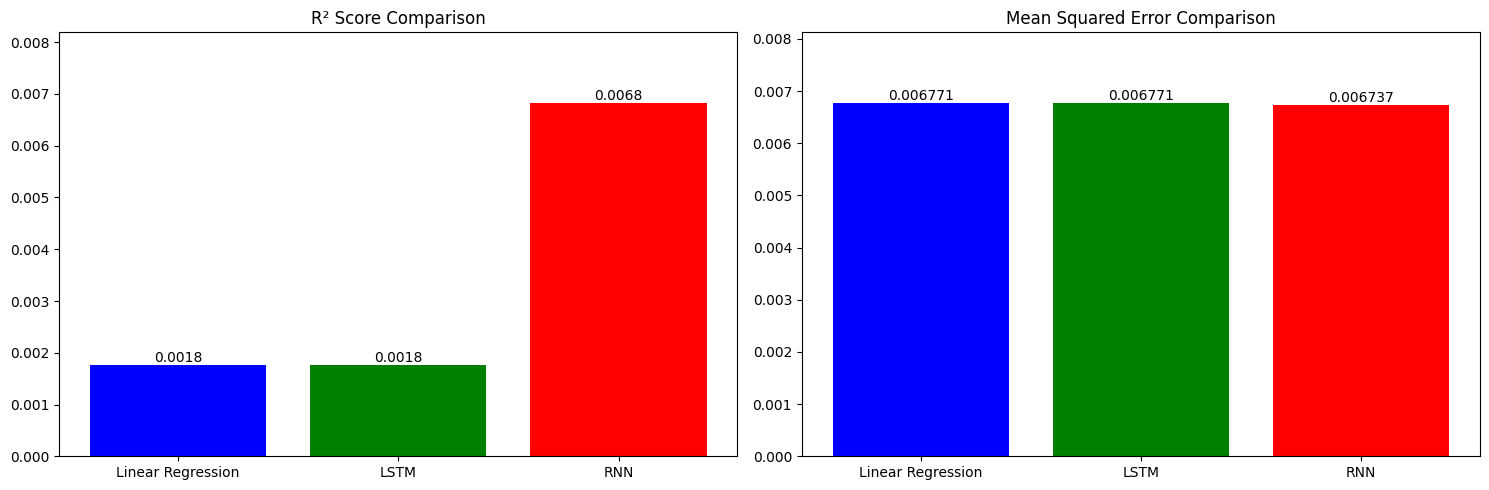

In [23]:
# Compare the performance of the three models
models = ['Linear Regression', 'LSTM', 'RNN']
r2_scores = [r2, r2_score(actuals, preds), rnn_r2]
mse_scores = [mse, mean_squared_error(actuals, preds), rnn_mse]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot R2 scores
ax1.bar(models, r2_scores, color=['blue', 'green', 'red'])
ax1.set_title('R² Score Comparison')
ax1.set_ylim([0, max(r2_scores) * 1.2])
for i, r2 in enumerate(r2_scores):
    ax1.text(i, r2, f"{r2:.4f}", ha='center', va='bottom')

# Plot MSE scores
ax2.bar(models, mse_scores, color=['blue', 'green', 'red'])
ax2.set_title('Mean Squared Error Comparison')
ax2.set_ylim([0, max(mse_scores) * 1.2])
for i, mse in enumerate(mse_scores):
    ax2.text(i, mse, f"{mse:.6f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()